In [2]:
from src.data.dataloader import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [3]:
dataloader = DataLoader()
characters = dataloader.load_characters()
movies_with_characters = dataloader.load_movies_with_characters()

def create_dummies_from_list_column(df, column_name):
    # Split the string entries into lists
    split_series = df[column_name].str.split(', ')
    # Create a new DataFrame with dummy variables
    dummy_df = pd.get_dummies(split_series.apply(pd.Series).stack(), prefix=column_name).groupby(level=0).sum()
    # Merge the dummy variables into the original DataFrame
    df = pd.concat([df, dummy_df], axis=1)
    # Drop the original column
    df = df.drop(column_name, axis=1)
    return df

def replace_with_mean_median_std_min_max(df, column_name):
    # Split the ages into lists, cleaning up any whitespace or invalid entries
    df[column_name] = df[column_name].str.split(', ').apply(
        lambda x: [float(age.strip()) for age in x if age.strip().replace('.', '', 1).isdigit()]
    )
    # Calculate mean, median, std, min, and max, handling empty lists
    #df[f'{column_name}_mean'] = df[column_name].apply(
    #    lambda x: sum(x) / len(x) if len(x) > 0 else None
    #)
    # df[f'{column_name}_median'] = df[column_name].apply(
    #     lambda x: sorted(x)[len(x) // 2] if len(x) % 2 == 1 else 
    #     (sorted(x)[len(x) // 2 - 1] + sorted(x)[len(x) // 2]) / 2 if len(x) > 0 else None
    # )
    # df[f'{column_name}_std'] = df[column_name].apply(
    #     lambda x: (sum((xi - sum(x) / len(x)) ** 2 for xi in x) / len(x)) ** 0.5 if len(x) > 0 else None
    # )
    df[f'{column_name}_min'] = df[column_name].apply(
        lambda x: min(x) if len(x) > 0 else None
    )
    df[f'{column_name}_max'] = df[column_name].apply(
        lambda x: max(x) if len(x) > 0 else None
    )
    # Drop the original column
    df = df.drop(column_name, axis=1)
    return df

/Users/omarbadri/Documents/MA3/ADA/ada-2024-project-insightmasters24/src/data/dataloader.py:172: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  tmdb_df = pd.read_csv(self.paths["tmdb_movies"])
/Users/omarbadri/Documents/MA3/ADA/ada-2024-project-insightmasters24/src/data/dataloader.py:172: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  tmdb_df = pd.read_csv(self.paths["tmdb_movies"])
/Users/omarbadri/Documents/MA3/ADA/ada-2024-project-insightmasters24/src/data/dataloader.py:172: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  tmdb_df = pd.read_csv(self.paths["tmdb_movies"])


In [4]:
df = movies_with_characters.drop(["wikipedia_movie_id", "wikidata_movie_id", "Movie name", "character_name", "plot"], axis=1)
df = df.dropna()
df = df[df["Movie box office revenue"] != 0]
display(df.columns)

Index(['Movie release date', 'Movie box office revenue', 'Movie languages',
       'Movie countries', 'Movie genres', 'actor_gender',
       'actor_height_meters', 'actor_age_at_release', 'ethnicity'],
      dtype='object')

In [5]:

df = create_dummies_from_list_column(df, 'actor_gender')
df = df.drop("actor_gender_", axis=1)
df["F ratio"] = df["actor_gender_F"] / (df["actor_gender_M"]+df["actor_gender_F"])

df = replace_with_mean_median_std_min_max(df, 'actor_age_at_release')
df = replace_with_mean_median_std_min_max(df, 'actor_height_meters')

df_with_countries = create_dummies_from_list_column(df, 'Movie countries')
df = df[df_with_countries["Movie countries_United States of America"] == 1]

df_with_countries = create_dummies_from_list_column(df, 'Movie languages')
df = df[df_with_countries["Movie languages_English Language"] == 1]

df = create_dummies_from_list_column(df, 'ethnicity')
df = create_dummies_from_list_column(df, 'Movie genres')

df = df.drop(["Movie languages", "ethnicity_", "Movie genres_", "Movie countries"], axis=1)
df.dropna(inplace=True)

ethnicity_columns = [col for col in df.columns if col.lower().startswith('ethnicity')]
genre_columns = [col for col in df.columns if col.lower().startswith('movie genres')]

display(df.columns)

Index(['Movie release date', 'Movie box office revenue', 'actor_gender_F',
       'actor_gender_M', 'F ratio', 'actor_age_at_release_min',
       'actor_age_at_release_max', 'actor_height_meters_min',
       'actor_height_meters_max', 'ethnicity_Acadians',
       ...
       'Movie genres_Vampire movies', 'Movie genres_War film',
       'Movie genres_Werewolf fiction', 'Movie genres_Western',
       'Movie genres_Whodunit', 'Movie genres_Women in prison films',
       'Movie genres_Workplace Comedy', 'Movie genres_World cinema',
       'Movie genres_Wuxia', 'Movie genres_Zombie Film'],
      dtype='object', length=573)

In [6]:
#We compare heights wrt a reference of 160 cm :
#df['actor_height_meters_mean'] = df['actor_height_meters_mean'] * 100 - 160
df['actor_height_meters_min'] = df['actor_height_meters_min'] * 100 - 160 
df['actor_height_meters_max'] = df['actor_height_meters_max'] * 100 - 160


In [17]:
ethnicity_mapping = {
    "African Ethnicities": [
        "ethnicity_African Americans", "ethnicity_African people", "ethnicity_Afro-Asians",
        "ethnicity_Afro-Cuban", "ethnicity_Berber", "ethnicity_Nigerian Americans",
        "ethnicity_Sierra Leone Creole people", "ethnicity_Somalis", "ethnicity_Sudanese Arabs",
        "ethnicity_Wolof people", "ethnicity_Xhosa people", "ethnicity_Yoruba people"
    ],
    "Indigenous Peoples": [
        "ethnicity_Apache", "ethnicity_Cherokee", "ethnicity_Choctaw", "ethnicity_Cree",
        "ethnicity_Haudenosaunee", "ethnicity_Lumbee", "ethnicity_Māori", "ethnicity_Mohawk people",
        "ethnicity_Native Hawaiians", "ethnicity_Ojibwe", "ethnicity_Omaha people",
        "ethnicity_Sámi peoples", "ethnicity_Sioux", "ethnicity_Inuit", "ethnicity_Inupiat people",
        "ethnicity_Aymara", "ethnicity_Blackfoot Confederacy"
    ],
    "Western European Ethnicities": [
        "ethnicity_Anglo-Celtic Australians", "ethnicity_Anglo-Irish people", "ethnicity_Belgians",
        "ethnicity_British Americans", "ethnicity_British Asian", "ethnicity_British Chinese",
        "ethnicity_British Indian", "ethnicity_British Jews", "ethnicity_British Pakistanis",
        "ethnicity_Dutch", "ethnicity_Dutch Americans", "ethnicity_Dutch Australian",
        "ethnicity_Dutch Canadians", "ethnicity_English Americans", "ethnicity_English Australian",
        "ethnicity_English Canadians", "ethnicity_English people", "ethnicity_French",
        "ethnicity_French Americans", "ethnicity_French Canadians", "ethnicity_Germans",
        "ethnicity_German Americans", "ethnicity_German Canadians"
    ],
    "Northern European Ethnicities": [
        "ethnicity_Danes", "ethnicity_Danish Americans", "ethnicity_Danish Canadians",
        "ethnicity_Finns", "ethnicity_Finnish Americans", "ethnicity_Icelanders",
        "ethnicity_Norwegian Americans", "ethnicity_Norwegians", "ethnicity_Swedes",
        "ethnicity_Swedish Americans", "ethnicity_Swedish Canadians"
    ],
    "Southern European Ethnicities": [
        "ethnicity_Albanians", "ethnicity_Albanian American", "ethnicity_Armenians",
        "ethnicity_Armenian American", "ethnicity_Corsicans", "ethnicity_Greek Americans",
        "ethnicity_Greek Canadians", "ethnicity_Greeks in South Africa", "ethnicity_Italians",
        "ethnicity_Italian Americans", "ethnicity_Italian Australian", "ethnicity_Italian Brazilians",
        "ethnicity_Italian Canadians", "ethnicity_Maltese", "ethnicity_Portuguese",
        "ethnicity_Portuguese Americans", "ethnicity_Sicilian Americans", "ethnicity_Spaniards",
        "ethnicity_Spanish Americans"
    ],
    "Eastern European Ethnicities": [
        "ethnicity_Baltic Russians", "ethnicity_Belarusians", "ethnicity_Bosnians",
        "ethnicity_Bulgarians", "ethnicity_Bulgarian Canadians", "ethnicity_Croats",
        "ethnicity_Croatian Americans", "ethnicity_Croatian Australians", "ethnicity_Croatian Canadians",
        "ethnicity_Czechs", "ethnicity_Czech Americans", "ethnicity_Hungarians",
        "ethnicity_Hungarian Americans", "ethnicity_Latvians", "ethnicity_Latvian American",
        "ethnicity_Lithuanian Jews", "ethnicity_Lithuanian American", "ethnicity_Poles",
        "ethnicity_Polish Americans", "ethnicity_Polish Australians", "ethnicity_Polish Canadians",
        "ethnicity_Romani people", "ethnicity_Romanian Americans", "ethnicity_Romanichal",
        "ethnicity_Russians", "ethnicity_Russian Americans", "ethnicity_Serbs in the United Kingdom",
        "ethnicity_Serbs of Croatia", "ethnicity_Serbs", "ethnicity_Serbian Americans",
        "ethnicity_Serbian Australians", "ethnicity_Serbian Canadians", "ethnicity_Slovaks",
        "ethnicity_Slovak Americans", "ethnicity_Slovenes", "ethnicity_Slovene Americans",
        "ethnicity_Tatars", "ethnicity_Ukrainians", "ethnicity_Ukrainian Americans",
        "ethnicity_Ukrainian Canadians"
    ],
    "Asian Ethnicities": [
        "ethnicity_Afro-Asians", "ethnicity_Assyrian people", "ethnicity_Bengali", "ethnicity_Bhutia",
        "ethnicity_Chinese Americans", "ethnicity_Chinese Canadians", "ethnicity_Chinese Filipino",
        "ethnicity_Chinese Jamaicans", "ethnicity_Chinese Singaporeans", "ethnicity_Filipino Americans",
        "ethnicity_Filipino Australians", "ethnicity_Filipino mestizo", "ethnicity_Filipino people",
        "ethnicity_Gujarati people", "ethnicity_Hazaras", "ethnicity_Hmong American", "ethnicity_Indian",
        "ethnicity_Indian Americans", "ethnicity_Indian diaspora in France", "ethnicity_Indo-Canadians",
        "ethnicity_Indonesian Americans", "ethnicity_Iranian peoples", "ethnicity_Japanese Brazilians",
        "ethnicity_Japanese people", "ethnicity_Kashmiri Pandit", "ethnicity_Korean American",
        "ethnicity_Koreans", "ethnicity_Malaysian Chinese", "ethnicity_Manchu", "ethnicity_Taiwanese",
        "ethnicity_Taiwanese Americans", "ethnicity_Tamil", "ethnicity_Telugu people",
        "ethnicity_Thai Americans", "ethnicity_Tibetan people"
    ],
    "Middle Eastern and Arab Ethnicities": [
        "ethnicity_Arab Americans", "ethnicity_Arabs in Bulgaria", "ethnicity_Iranian Americans",
        "ethnicity_Iranians in the United Kingdom", "ethnicity_Iraqis", "ethnicity_Iraqi Americans",
        "ethnicity_Lebanese", "ethnicity_Lebanese Americans", "ethnicity_Moroccans",
        "ethnicity_Palestinian Americans", "ethnicity_Sudanese Arabs"
    ],
    "Latin American Ethnicities": [
        "ethnicity_Afro-Cuban", "ethnicity_Argentines", "ethnicity_Brazilian Americans",
        "ethnicity_Brazilians", "ethnicity_Chilean American", "ethnicity_Chileans",
        "ethnicity_Colombian Americans", "ethnicity_Colombians", "ethnicity_Cuban Americans",
        "ethnicity_Cubans", "ethnicity_Dominican Americans", "ethnicity_Ecuadorian Americans",
        "ethnicity_Honduran Americans", "ethnicity_Hondurans", "ethnicity_Latino",
        "ethnicity_Mexican Americans", "ethnicity_Mexicans", "ethnicity_Panamanian Americans",
        "ethnicity_Puerto Ricans", "ethnicity_Salvadoran Americans", "ethnicity_Uruguayans",
        "ethnicity_Venezuelan Americans", "ethnicity_Venezuelans"
    ],
    "Jewish Communities": [
        "ethnicity_American Jews", "ethnicity_Ashkenazi Jews", "ethnicity_British Jews",
        "ethnicity_Sephardi Jews", "ethnicity_Israelis", "ethnicity_Israeli Americans",
        "ethnicity_Jewish people", "ethnicity_Lithuanian Jews", "ethnicity_History of the Jews in Morocco"
    ],
    "American Ethnicities": [
        "ethnicity_Acadians", "ethnicity_African Americans", "ethnicity_American Jews",
        "ethnicity_Anglo-Celtic Australians", "ethnicity_Apache", "ethnicity_Asian Americans",
        "ethnicity_Australian Americans", "ethnicity_Bahamian Americans", "ethnicity_Brazilian Americans",
        "ethnicity_British Americans", "ethnicity_Cajun", "ethnicity_Cherokee", "ethnicity_Chilean American",
        "ethnicity_Chinese Americans", "ethnicity_Colombian Americans", "ethnicity_Cuban Americans",
        "ethnicity_Danish Americans", "ethnicity_Dominican Americans", "ethnicity_Ecuadorian Americans",
        "ethnicity_English Americans", "ethnicity_Filipino Americans", "ethnicity_First Nations",
        "ethnicity_French Americans", "ethnicity_German Americans", "ethnicity_Greek Americans",
        "ethnicity_Haitian Americans", "ethnicity_Hmong American", "ethnicity_Indian Americans",
        "ethnicity_Irish Americans", "ethnicity_Italian Americans", "ethnicity_Korean American",
        "ethnicity_Mexican Americans", "ethnicity_Native Hawaiians"
    ],
    "Oceanian Ethnicities": [
        "ethnicity_Australian Americans", "ethnicity_Australians", "ethnicity_Filipino Australians",
        "ethnicity_Irish Australian", "ethnicity_Italian Australian", "ethnicity_Māori"
    ]
}

genre_mapping = {
    "Action": [
        "Movie genres_Action", "Movie genres_Action Comedy", "Movie genres_Action Thrillers",
        "Movie genres_Action/Adventure", "Movie genres_Biker Film", "Movie genres_Buddy cop",
        "Movie genres_Chase Movie", "Movie genres_Disaster", "Movie genres_Martial Arts Film",
        "Movie genres_Ninja movie", "Movie genres_Superhero", "Movie genres_Superhero movie",
        "Movie genres_Swashbuckler films", "Movie genres_Sword and sorcery", "Movie genres_Spy"
    ],
    "Adventure": [
        "Movie genres_Action/Adventure", "Movie genres_Adventure", "Movie genres_Adventure Comedy",
        "Movie genres_Costume Adventure", "Movie genres_Fantasy Adventure",
        "Movie genres_Family-Oriented Adventure", "Movie genres_Sci-Fi Adventure",
        "Movie genres_Sword and Sandal", "Movie genres_Archaeology", "Movie genres_Space western"
    ],
    "Comedy": [
        "Movie genres_Action Comedy", "Movie genres_Black comedy", "Movie genres_Camp",
        "Movie genres_Comedy", "Movie genres_Comedy Thriller", "Movie genres_Comedy Western",
        "Movie genres_Comedy horror", "Movie genres_Comedy-drama", "Movie genres_Comedy of Errors",
        "Movie genres_Comedy of manners", "Movie genres_Domestic Comedy", "Movie genres_Heavenly Comedy",
        "Movie genres_Musical comedy", "Movie genres_Parody", "Movie genres_Romantic comedy",
        "Movie genres_Screwball comedy", "Movie genres_Stand-up comedy", "Movie genres_Sex comedy",
        "Movie genres_Stoner film", "Movie genres_Workplace Comedy"
    ],
    "Drama": [
        "Movie genres_Addiction Drama", "Movie genres_Biographical film", "Movie genres_Biopic [feature]",
        "Movie genres_Childhood Drama", "Movie genres_Coming-of-age film", "Movie genres_Courtroom Drama",
        "Movie genres_Costume drama", "Movie genres_Family Drama", "Movie genres_Historical drama",
        "Movie genres_Melodrama", "Movie genres_Political drama", "Movie genres_Romantic drama",
        "Movie genres_Social problem film", "Movie genres_Tragedy"
    ],
    "Fantasy and Science Fiction": [
        "Movie genres_Alien Film", "Movie genres_Alien invasion", "Movie genres_Apocalyptic and post-apocalyptic fiction",
        "Movie genres_Fairy tale", "Movie genres_Fantasy", "Movie genres_Fantasy Adventure",
        "Movie genres_Fantasy Comedy", "Movie genres_Fantasy Drama", "Movie genres_Mythological Fantasy",
        "Movie genres_Science Fiction", "Movie genres_Space opera", "Movie genres_Steampunk",
        "Movie genres_Supernatural", "Movie genres_Sword and sorcery", "Movie genres_Time travel"
    ],
    "Horror": [
        "Movie genres_Comedy horror", "Movie genres_Creature Film", "Movie genres_Costume Horror",
        "Movie genres_Demonic child", "Movie genres_Doomsday film", "Movie genres_Horror",
        "Movie genres_Haunted House Film", "Movie genres_Horror Comedy", "Movie genres_Natural horror films",
        "Movie genres_Period Horror", "Movie genres_Psychological horror", "Movie genres_Slasher",
        "Movie genres_Splatter film", "Movie genres_Road-Horror", "Movie genres_Vampire movies",
        "Movie genres_Werewolf fiction", "Movie genres_Zombie Film"
    ],
    "Romance": [
        "Movie genres_Romance Film", "Movie genres_Romantic comedy", "Movie genres_Romantic drama",
        "Movie genres_Romantic fantasy", "Movie genres_Heaven-Can-Wait Fantasies", "Movie genres_Tragicomedy"
    ],
    "Documentary": [
        "Movie genres_Docudrama", "Movie genres_Documentary", "Movie genres_Educational",
        "Movie genres_Environmental Science", "Movie genres_Film & Television History",
        "Movie genres_Journalism", "Movie genres_News", "Movie genres_Rockumentary",
        "Movie genres_Social issues", "Movie genres_Culture & Society", "Movie genres_History"
    ],
    "Crime and Mystery": [
        "Movie genres_Caper story", "Movie genres_Crime", "Movie genres_Crime Comedy",
        "Movie genres_Crime Drama", "Movie genres_Crime Fiction", "Movie genres_Crime Thriller",
        "Movie genres_Detective", "Movie genres_Detective fiction", "Movie genres_Film noir",
        "Movie genres_Heist", "Movie genres_Master Criminal Films", "Movie genres_Mystery",
        "Movie genres_Neo-noir", "Movie genres_Political thriller", "Movie genres_Psychological thriller",
        "Movie genres_Suspense", "Movie genres_Whodunit"
    ],
    "Musicals and Dance": [
        "Movie genres_Animated Musical", "Movie genres_Backstage Musical", "Movie genres_Breakdance",
        "Movie genres_Jukebox musical", "Movie genres_Musical", "Movie genres_Musical Drama",
        "Movie genres_Musical comedy", "Movie genres_Rockumentary", "Movie genres_Dance"
    ],
    "War and Political": [
        "Movie genres_Anti-war", "Movie genres_Anti-war film", "Movie genres_Cold War",
        "Movie genres_Combat Films", "Movie genres_Glamorized Spy Film", "Movie genres_Gulf War",
        "Movie genres_Historical Epic", "Movie genres_Political cinema", "Movie genres_Political drama",
        "Movie genres_Political satire", "Movie genres_Political thriller", "Movie genres_Propaganda film",
        "Movie genres_War film", "Movie genres_The Netherlands in World War II"
    ],
    "Family and Children": [
        "Movie genres_Children's", "Movie genres_Children's Fantasy", "Movie genres_Children's/Family",
        "Movie genres_Family Film", "Movie genres_Family Drama", "Movie genres_Family-Oriented Adventure",
        "Movie genres_Family & Personal Relationships", "Movie genres_Christmas movie", "Movie genres_Animated Musical"
    ],
    "Animation": [
        "Movie genres_Animated cartoon", "Movie genres_Animation", "Movie genres_Anime",
        "Movie genres_Computer Animation", "Movie genres_Stop motion", "Movie genres_Supermarionation"
    ],
    "Sports": [
        "Movie genres_Auto racing", "Movie genres_Baseball", "Movie genres_Boxing",
        "Movie genres_Extreme Sports", "Movie genres_Horse racing", "Movie genres_Sports"
    ],
    "Experimental and Independent": [
        "Movie genres_Absurdism", "Movie genres_Avant-garde", "Movie genres_Art film",
        "Movie genres_Experimental film", "Movie genres_Indie", "Movie genres_Mockumentary",
        "Movie genres_Mumblecore"
    ],
    "LGBT and Gender Issues": [
        "Movie genres_Feminist Film", "Movie genres_Gay", "Movie genres_Gay Interest",
        "Movie genres_Gay Themed", "Movie genres_Gender Issues", "Movie genres_LGBT"
    ],
    "Erotic and Adult": [
        "Movie genres_Adult", "Movie genres_Erotica", "Movie genres_Erotic Drama",
        "Movie genres_Erotic thriller", "Movie genres_Gay pornography", "Movie genres_Hardcore pornography",
        "Movie genres_Sexploitation", "Movie genres_Softcore Porn"
    ]
}

# First create the grouped ethnicity categories
for category, columns in ethnicity_mapping.items():
    existing_columns = [col for col in columns if col in df.columns]
    if existing_columns:
        df[category] = df[existing_columns].sum(axis=1)

# Calculate ethnic_score using the grouped categories
df['ethnic_score'] = (df[ethnicity_mapping.keys()] > 0).sum(axis=1)

# Get list of ethnicity columns that actually exist in the dataframe
existing_ethnicity_columns = [col for col in ethnicity_columns if col in df.columns]
existing_genre_columns = [col for col in genre_columns if col in df.columns]

# Drop only the existing columns
df = df.drop(columns=existing_ethnicity_columns, axis=1)
df = df.drop(columns=existing_genre_columns, axis=1)

print("Dataset with grouped ethnicity-genre columns:")
df.head()

Dataset with grouped ethnicity-genre columns:


,Movie release date,Movie box office revenue,actor_gender_F,actor_gender_M,F ratio,actor_age_at_release_min,actor_age_at_release_max,actor_height_meters_min,actor_height_meters_max,African Ethnicities,...,Musicals and Dance,War and Political,Family and Children,Animation,Sports,Experimental and Independent,LGBT and Gender Issues,Erotic and Adult,ethnic_score,period
30901,1910,10424470.0,9,18,0.333333,18.0,23.0,-5.0,17.0,0,...,0,0,0,0,0,1,0,0,1,1910-1914
35918,1914,263591415.0,121,0,1.000000,22.0,22.0,-6.0,-6.0,0,...,0,0,0,0,0,0,0,0,0,1910-1914
2,1915,50000000.0,24,32,0.428571,12.0,56.0,0.0,20.0,0,...,0,1,0,0,0,1,0,0,0,1915-1919
34688,1916,38901218.0,8,16,0.333333,31.0,58.0,8.0,8.0,0,...,0,0,0,0,0,0,0,0,1,1915-1919
28934,1916,1143856.0,0,1,0.000000,29.0,29.0,18.0,18.0,0,...,0,0,0,0,0,1,0,0,0,1915-1919


In [18]:
#We sort the movies by movie release date: 
df = df.sort_values(by="Movie release date")

In [19]:
df

,Movie release date,Movie box office revenue,actor_gender_F,actor_gender_M,F ratio,actor_age_at_release_min,actor_age_at_release_max,actor_height_meters_min,actor_height_meters_max,African Ethnicities,...,Musicals and Dance,War and Political,Family and Children,Animation,Sports,Experimental and Independent,LGBT and Gender Issues,Erotic and Adult,ethnic_score,period
30901,1910,10424470.0,9,18,0.333333,18.0,23.0,-5.0,17.0,0,...,0,0,0,0,0,1,0,0,1,1910-1914
35918,1914,263591415.0,121,0,1.000000,22.0,22.0,-6.0,-6.0,0,...,0,0,0,0,0,0,0,0,0,1910-1914
2,1915,50000000.0,24,32,0.428571,12.0,56.0,0.0,20.0,0,...,0,1,0,0,0,1,0,0,0,1915-1919
34688,1916,38901218.0,8,16,0.333333,31.0,58.0,8.0,8.0,0,...,0,0,0,0,0,0,0,0,1,1915-1919
28934,1916,1143856.0,0,1,0.000000,29.0,29.0,18.0,18.0,0,...,0,0,0,0,0,1,0,0,0,1915-1919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60645,2012,2610511.0,5,11,0.312500,21.0,41.0,-3.0,33.0,1,...,0,0,0,0,0,0,0,0,4,2010-2014
59656,2012,175705.0,0,1,0.000000,39.0,39.0,17.0,17.0,0,...,0,0,0,0,0,0,0,0,0,2010-2014
47971,2012,302836260.0,3,12,0.200000,24.0,60.0,13.0,34.0,0,...,0,0,0,0,0,0,0,0,1,2010-2014
60572,2012,4083984.0,7,8,0.466667,26.0,50.0,0.0,17.0,0,...,0,0,0,0,0,0,0,0,2,2010-2014


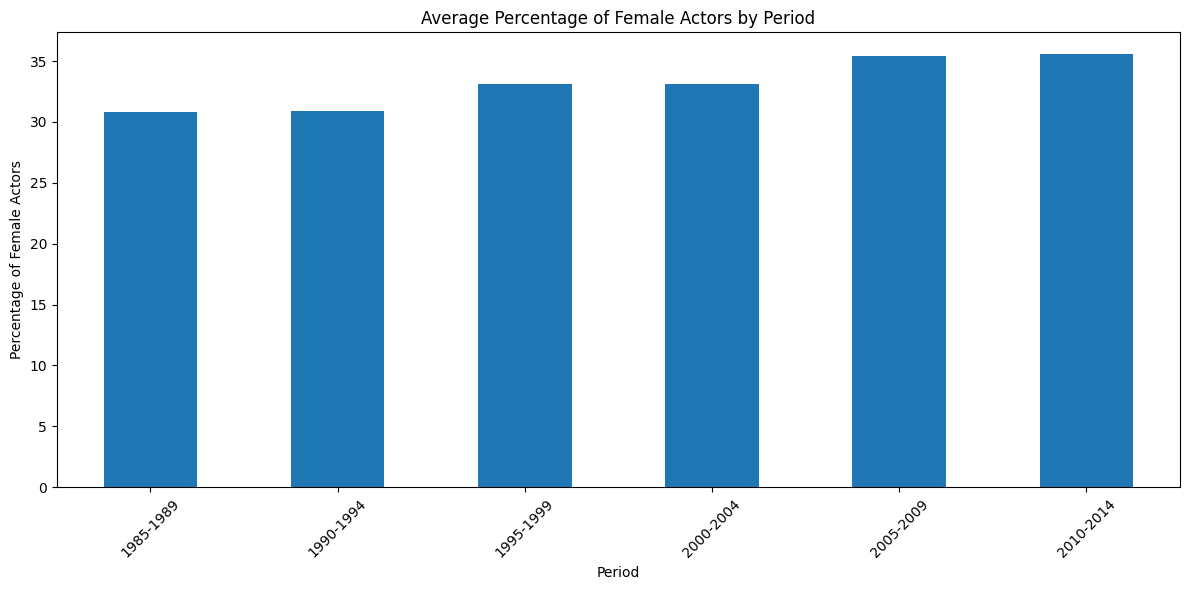

In [33]:
def plot_female_ratio_distribution(df):
    """
    Creates a bar plot showing the distribution of female actor ratios over time periods.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing 'Movie release date' and 'F ratio' columns
    
    Returns:
    None (displays plot and prints percentages)
    """
    df['period'] = pd.to_datetime(df['Movie release date'], format='%Y').dt.year.apply(
        lambda x: f"{(x//5)*5}-{(x//5)*5+4}"
    )

    period_f_ratios = df.groupby('period')['F ratio'].mean() * 100  

    # Select only the periods we're interested in
    periods_of_interest = ['1985-1989', '1990-1994', '1995-1999', '2000-2004', '2005-2009', '2010-2014']
    f_ratios = period_f_ratios[periods_of_interest]

    plt.figure(figsize=(12, 6))
    f_ratios.plot(kind='bar')
    plt.title('Average Percentage of Female Actors by Period')
    plt.xlabel('Period')
    plt.ylabel('Percentage of Female Actors')
    plt.xticks(rotation=45)
    plt.tight_layout()

plot_female_ratio_distribution(df)

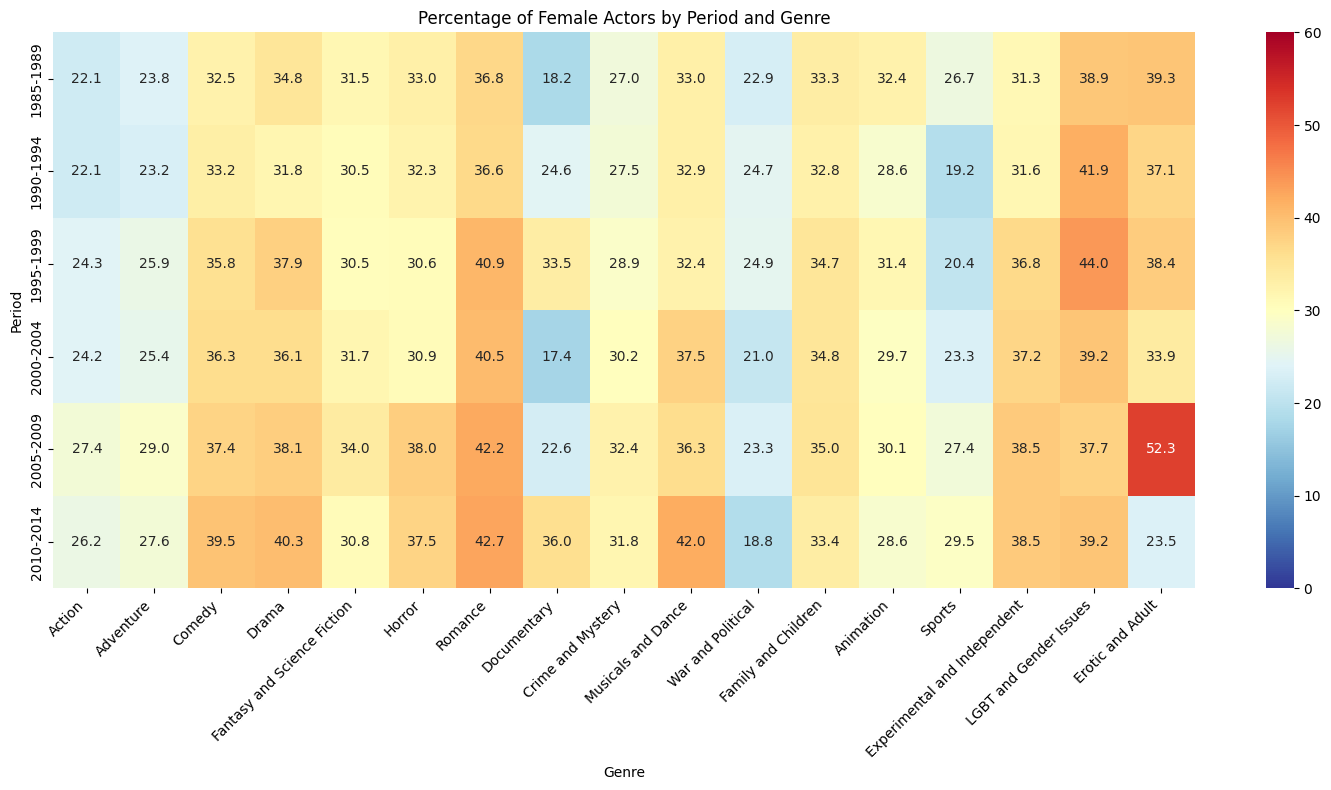

In [32]:
def plot_female_ratio_heatmap(df):
    """
    Creates a heatmap showing the percentage of female actors across different periods and genres.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing 'Movie release date', 'F ratio' and genre columns
    
    Returns:
    None (displays heatmap and prints averages)
    """
    genres = df.columns[df.columns.get_loc('Action'):df.columns.get_loc('Erotic and Adult')+1].tolist()
    
    # Define periods of interest
    periods_of_interest = ['1985-1989', '1990-1994', '1995-1999', '2000-2004', '2005-2009', '2010-2014']

    heatmap_data = []

    # For each period and genre, we calculate average F ratio for movies of that genre
    for period in periods_of_interest:
        period_data = df[df['period'] == period]
        row_data = []
        for genre in genres:
            genre_movies = period_data[period_data[genre] == 1]
            if len(genre_movies) > 0:
                f_ratio = genre_movies['F ratio'].mean() * 100
                row_data.append(f_ratio)
            else:
                row_data.append(0)
        heatmap_data.append(row_data)

    heatmap_df = pd.DataFrame(heatmap_data, 
                             index=periods_of_interest,
                             columns=genres)

    plt.figure(figsize=(15, 8))
    sns.heatmap(heatmap_df, 
                annot=True,  
                fmt='.1f',   
                cmap='RdYlBu_r',  
                center=30,    
                vmin=0,      
                vmax=60)     

    plt.title('Percentage of Female Actors by Period and Genre')
    plt.xlabel('Genre')
    plt.ylabel('Period')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

# Usage example:
plot_female_ratio_heatmap(df)

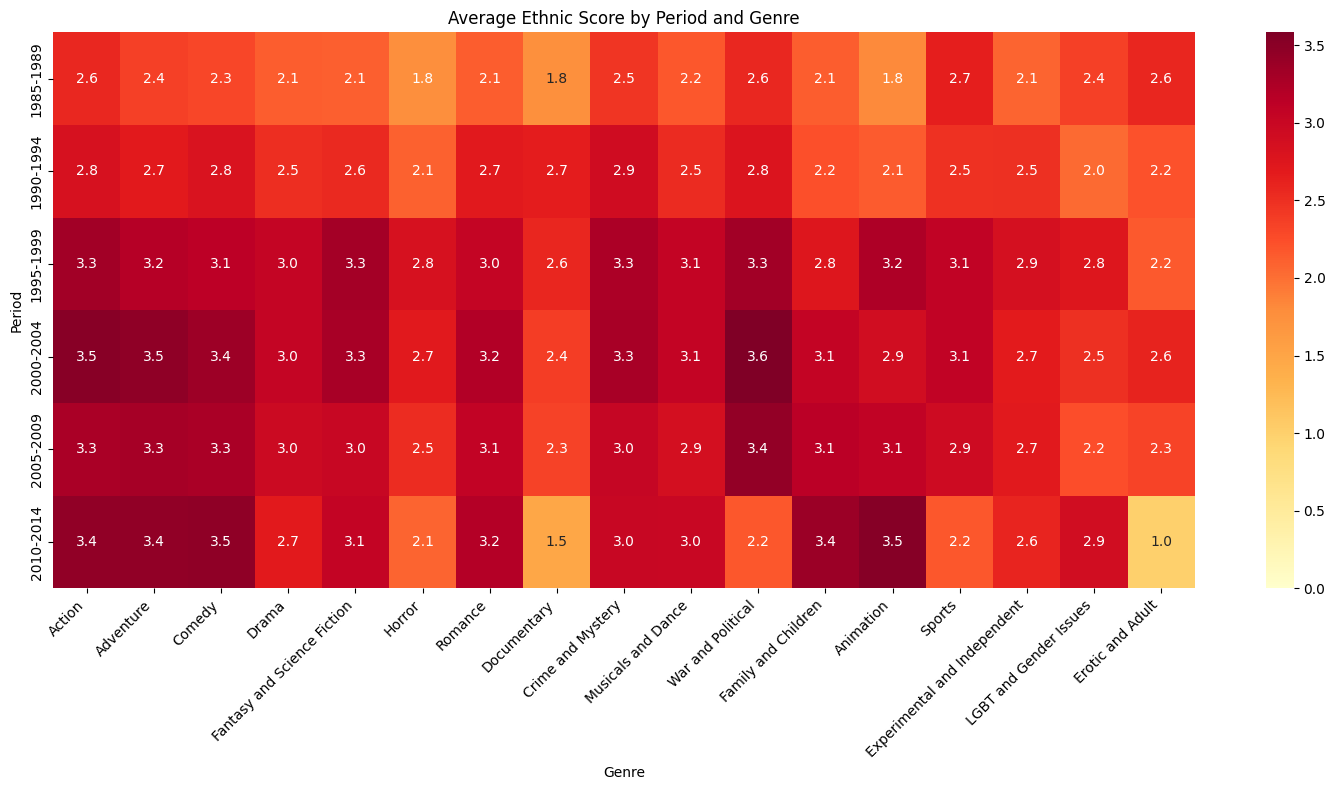

In [31]:
def plot_ethnic_score_heatmap(df):
    """
    Creates a heatmap showing the average ethnic score across different periods and genres.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing 'Movie release date', 'ethnic_score' and genre columns
    
    Returns:
    None (displays heatmap and prints averages)
    """
    genres = df.columns[df.columns.get_loc('Action'):df.columns.get_loc('Erotic and Adult')+1].tolist()
    
    # Define periods of interest
    periods_of_interest = ['1985-1989', '1990-1994', '1995-1999', '2000-2004', '2005-2009', '2010-2014']

    heatmap_data = []

    # For each period and genre, calculate average ethnic_score for movies of that genre
    for period in periods_of_interest:
        period_data = df[df['period'] == period]
        row_data = []
        for genre in genres:
            genre_movies = period_data[period_data[genre] == 1]
            if len(genre_movies) > 0:
                avg_score = genre_movies['ethnic_score'].mean()
                row_data.append(avg_score)
            else:
                row_data.append(0)
        heatmap_data.append(row_data)

    heatmap_df = pd.DataFrame(heatmap_data, 
                             index=periods_of_interest,
                             columns=genres)

    plt.figure(figsize=(15, 8))
    sns.heatmap(heatmap_df, 
                annot=True,  
                fmt='.1f',   
                cmap='YlOrRd',  
                center=None,    
                vmin=0)    

    plt.title('Average Ethnic Score by Period and Genre')
    plt.xlabel('Genre')
    plt.ylabel('Period')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
# Usage example:
plot_ethnic_score_heatmap(df)

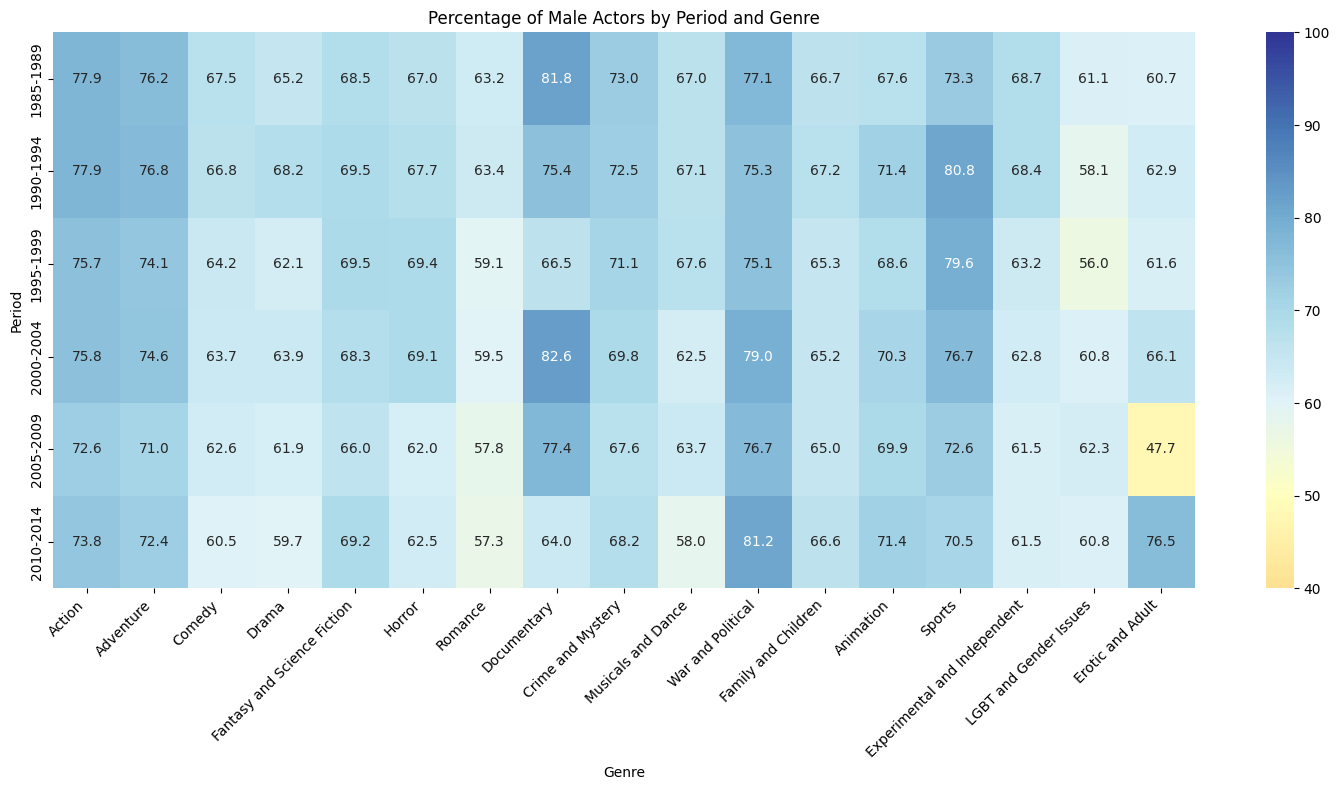

In [30]:
def plot_male_ratio_heatmap(df):
    """
    Creates a heatmap showing the percentage of male actors across different periods and genres.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing 'Movie release date', 'F ratio' and genre columns
    
    Returns:
    None (displays heatmap and prints averages)
    """
    genres = df.columns[df.columns.get_loc('Action'):df.columns.get_loc('Erotic and Adult')+1].tolist()
    
    # Define periods of interest
    periods_of_interest = ['1985-1989', '1990-1994', '1995-1999', '2000-2004', '2005-2009', '2010-2014']

    heatmap_data = []

    # For each period and genre, calculate average male proportion (1 - F ratio) for movies of that genre
    for period in periods_of_interest:
        period_data = df[df['period'] == period]
        row_data = []
        for genre in genres:
            genre_movies = period_data[period_data[genre] == 1]
            if len(genre_movies) > 0:
                m_ratio = (1 - genre_movies['F ratio']).mean() * 100 
                row_data.append(m_ratio)
            else:
                row_data.append(0)
        heatmap_data.append(row_data)

    heatmap_df = pd.DataFrame(heatmap_data, 
                             index=periods_of_interest,
                             columns=genres)

    plt.figure(figsize=(15, 8))
    sns.heatmap(heatmap_df, 
                annot=True,  
                fmt='.1f',   
                cmap='RdYlBu',  
                center=50,   
                vmin=40,     
                vmax=100)    
    plt.title('Percentage of Male Actors by Period and Genre')
    plt.xlabel('Genre')
    plt.ylabel('Period')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

# Usage example:
plot_male_ratio_heatmap(df)